In [1]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import skvideo
skvideo.setFFmpegPath('D:/GeekBrains/comp_vision/les07/ffmpeg-2021-12-12-git-996b13fac4-full_build/bin')
import skvideo.io
import tensorflow as tf

C:\Users\snetkova\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\snetkova\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\snetkova\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


#### load data

In [2]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []
data_root = 'D:/GeekBrains/comp_vision/les07/data/'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


#### visualize data

videodata shape: (555, 120, 160, 3)


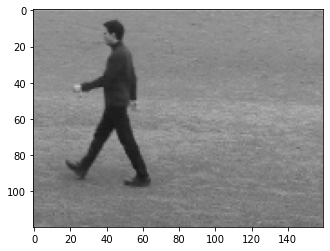

In [3]:
videodata = skvideo.io.vread(dataset[0][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
plt.imshow(videodata[50, ...])

motion shape: (554, 120, 160, 1)


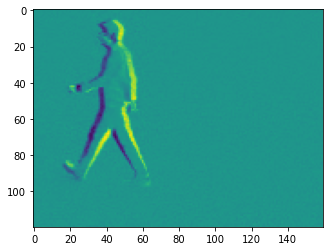

In [4]:
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[50, ..., 0])

#### datasets

In [5]:
from sklearn.model_selection import train_test_split

SUBSET_LEN = 300
random.shuffle(dataset)
dataset = dataset[:SUBSET_LEN]
train_x, valid_x, train_y, valid_y = train_test_split(np.array(dataset)[:, 0],
                                                      np.array(dataset)[:, 1],
                                                      test_size=0.25, random_state=42,
                                                      stratify=np.array(dataset)[:, 1])


train_x.shape, valid_x.shape

((225,), (75,))

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))

In [7]:
def fpath_to_video(fpath):
    fpath = fpath.numpy().decode('utf-8')
    videodata = skvideo.io.vread(fpath)
    videodata = videodata.astype(np.float32) / 255.
    # возвращаем 200 кадров из середины считанного ролика
    videodata = videodata[len(videodata)//2-100:len(videodata)//2+1+100, ...]
    return np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True) # motion

In [8]:
BATCH_SIZE = 2 # больше в GPU все равно не лезет

train_ds = train_ds.map(lambda fpath, label: (tf.py_function(fpath_to_video, [fpath], Tout=tf.float32),
                                            tf.numpy_function(np.int8, [label], tf.int8)))
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.batch(BATCH_SIZE)


valid_ds = valid_ds.map(lambda fpath, label: (tf.py_function(fpath_to_video, [fpath], Tout=tf.float32),
                                            tf.numpy_function(np.int8, [label], tf.int8)))
valid_ds = valid_ds.shuffle(buffer_size=1000)
valid_ds = valid_ds.batch(BATCH_SIZE)

#### model

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None)
])

In [10]:
NUM_EPOCHS = 20
LEARNING_RATE = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [11]:
for v, l in train_ds.take(1):
    print(v.shape) # video
    print(l.shape) # label
    print(model(v).shape) # output

(2, 200, 120, 160, 1)
(2,)
(2, 6)


In [12]:
%%time
# global_step = 0

train_losses = []
test_losses = []

for ep in range(NUM_EPOCHS):
    for i, (videodata, labels) in enumerate(train_ds):
        train_loss = model.train_on_batch(videodata, labels)

        if i % 10 == 0:
            test_loss = model.test_on_batch(videodata, labels)
            print(f'[{ep}/{NUM_EPOCHS}][{i}/{len(train_ds)}] train loss: {train_loss} | test loss: {test_loss}')
            train_losses.append(train_loss)
            test_losses.append(test_loss)
               
#         global_step += 1

[0/20][0/113] train loss: 1.791407585144043 | test loss: 1.7875633239746094
[0/20][10/113] train loss: 1.791182041168213 | test loss: 1.7908895015716553
[0/20][20/113] train loss: 1.7923927307128906 | test loss: 1.792136788368225
[0/20][30/113] train loss: 1.7933651208877563 | test loss: 1.7929840087890625
[0/20][40/113] train loss: 1.7869422435760498 | test loss: 1.7846295833587646
[0/20][50/113] train loss: 1.6865134239196777 | test loss: 1.6688851118087769
[0/20][60/113] train loss: 1.489515781402588 | test loss: 1.4308075904846191
[0/20][70/113] train loss: 1.3723855018615723 | test loss: 1.315812110900879
[0/20][80/113] train loss: 1.410579800605774 | test loss: 1.3716087341308594
[0/20][90/113] train loss: 1.4677793979644775 | test loss: 1.4331257343292236
[0/20][100/113] train loss: 1.0688458681106567 | test loss: 1.0254007577896118
[0/20][110/113] train loss: 0.8913334608078003 | test loss: 0.8906848430633545
[1/20][0/113] train loss: 1.0501937866210938 | test loss: 1.059801459

[8/20][90/113] train loss: 0.007190478499978781 | test loss: 0.007088467478752136
[8/20][100/113] train loss: 1.110321283340454 | test loss: 0.5996386408805847
[8/20][110/113] train loss: 0.9262303709983826 | test loss: 0.9058037996292114
[9/20][0/113] train loss: 0.2185603827238083 | test loss: 0.2021247297525406
[9/20][10/113] train loss: 0.09802480041980743 | test loss: 0.09171837568283081
[9/20][20/113] train loss: 0.1286393404006958 | test loss: 0.1347564458847046
[9/20][30/113] train loss: 0.028336014598608017 | test loss: 0.023731639608740807
[9/20][40/113] train loss: 0.3363891839981079 | test loss: 0.2657630145549774
[9/20][50/113] train loss: 0.08456156402826309 | test loss: 0.08181426674127579
[9/20][60/113] train loss: 0.6728196740150452 | test loss: 0.6441109776496887
[9/20][70/113] train loss: 1.761237382888794 | test loss: 1.4957994222640991
[9/20][80/113] train loss: 0.1559053212404251 | test loss: 0.1415281891822815
[9/20][90/113] train loss: 0.19888578355312347 | test

[17/20][30/113] train loss: 0.05972134321928024 | test loss: 0.059483852237463
[17/20][40/113] train loss: 0.5074001550674438 | test loss: 0.4743736684322357
[17/20][50/113] train loss: 0.1773204803466797 | test loss: 0.1649552285671234
[17/20][60/113] train loss: 0.002136371098458767 | test loss: 0.0021086987107992172
[17/20][70/113] train loss: 0.17527365684509277 | test loss: 0.1676502227783203
[17/20][80/113] train loss: 0.025328220799565315 | test loss: 0.01861189864575863
[17/20][90/113] train loss: 0.025761548429727554 | test loss: 0.025980303063988686
[17/20][100/113] train loss: 0.030835378915071487 | test loss: 0.027226470410823822
[17/20][110/113] train loss: 0.9253714084625244 | test loss: 0.8073540329933167
[18/20][0/113] train loss: 0.003791682654991746 | test loss: 0.003616391448304057
[18/20][10/113] train loss: 0.2120634764432907 | test loss: 0.19611144065856934
[18/20][20/113] train loss: 0.12525376677513123 | test loss: 0.11536022275686264
[18/20][30/113] train loss:

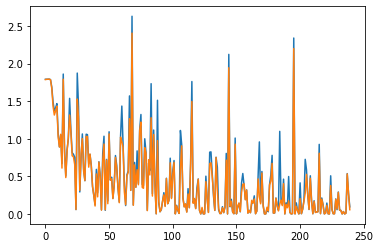

In [13]:
plt.plot(train_losses)
plt.plot(test_losses)

#### test data

In [18]:
def random_prediction():
    test_data = valid_ds.take(1)
    val = [(x,y) for x,y in test_data]
    test_x = val[0][0].numpy()
    test_y = val[0][1].numpy()

    true_class = test_y[0]
    pred_class = np.argmax(model(test_x).numpy()[0])

    plt.imshow(test_x[0][20, ...]) # в датасет брали не видео, а motion

    print('True class:', classes[true_class])
    print('Pred class:', classes[pred_class])

True class: boxing
Pred class: boxing


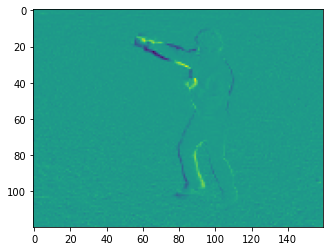

In [25]:
random_prediction()

True class: handwaving
Pred class: handwaving


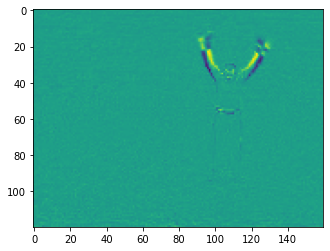

In [20]:
random_prediction()

True class: boxing
Pred class: handclapping


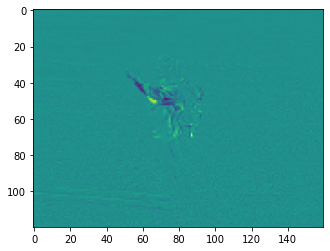

In [22]:
random_prediction()